# Do team colors influence sports success?

I was recently listening to conversation in a sports podcast about the upcoming Super Bowl and what color the teams would wear. This conversation was being had because both teams have colorways consisting of some shade of red, yellow, and white.

Once it was determined who the home team was and that their home jersey is red, one of the hosts said something like: "That's their advantage. They get to wear red. Red is a dominant color." They then had a short conversation around the stats of colors and team success, **so that's what we'll be looking into.**

To put this together, I scraped team primary + secondary colors (in hex) from [teamcolorcodes.com](https://teamcolorcodes.com/) for the MLB, NBA, NFL, NHL, Premier League (EPL), La Liga, Serie A, and the NCAA (Basketball + Football). These colors were by no means perfect for each team but they serve as a decent baseline.
* Furthermore, I used the [webcolors](https://webcolors.readthedocs.io/en/1.10/) package to convert the hex colors into both CSS2 and CSS3 color names.
* As well, I used the [wolframalpha](https://pypi.org/project/wolframalpha/) api to get english color names via the wolfram engine.

Lastly, I scraped Wikipedia for some tables of leagues, teams & their number of championships.

Let's get into it.

### Importing packages, data, and creating some plotting helpers

In [2]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import glob
import os

%matplotlib inline

# set styles
# plt.rcParams['font.family'] = 'Franklin Gothic Medium'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["axes.facecolor"] = "#F0F0F0"
plt.rcParams["figure.facecolor"] = "#F0F0F0"

In [3]:
# import data
colors = pd.read_csv('data/team_colors.csv')

# mash the csvs from each league together
champs_glob = glob.glob(os.path.join('data/champs', "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in champs_glob)
all_champs = pd.concat(df_from_each_file, ignore_index=True)

# join champions csv to the color csv on Team + League
data = colors.merge(all_champs, how = "right", on = ["Team", "League"])

# narrow down to teams that've won championshps
winners = data[data["Wins"] > 0]

# couldn't get the damn emojis to render
# winners = winners.replace({"EPL": "EPL⚽","La Liga": "La Liga⚽","Serie A": "Serie A⚽","NFL": "NFL🏈",
#                           "NBA": "NBA🏀","NHL": "NHL🏒","MLB": "MLB⚾","NCAA": "NCAA🏈🏀"})
# for tick in ax.get_xticklabels(): tick.set_fontname("Segoe UI Emoji")

winners.head()

,Team,hex_Primary_Color,hex_Secondary_Color,League,wc_css2_Primary_Name,wc_css2_Secondary_Name,wc_css3_Primary_Name,wc_css3_Secondary_Name,wa_Primary_Names,wa_Secondary_Names,wa_Primary_Name_1,wa_Primary_Name_2,wa_Secondary_Name_1,wa_Secondary_Name_2,Wins
2,Baltimore Ravens,#241773,#000000,NFL,Navy,Black,Midnightblue,Black,"midnight blue,navy","black,dim gray",Midnight Blue,Navy,Black,Dim Gray,2
5,Chicago Bears,#0B162A,#C83803,NFL,Black,Red,Black,Firebrick,"midnight blue,steel blue","orange red,chocolate",Midnight Blue,Steel Blue,Orange Red,Chocolate,1
8,Dallas Cowboys,#041E42,#869397,NFL,Navy,Gray,Midnightblue,Lightslategray,"navy,dark blue","light slate gray,slate gray",Navy,Dark Blue,Light Slate Gray,Slate Gray,5
9,Denver Broncos,#002244,#FB4F14,NFL,Navy,Red,Midnightblue,Orangered,"navy,teal","orange red,chocolate",Navy,Teal,Orange Red,Chocolate,3
11,Green Bay Packers,#203731,#FFB612,NFL,Black,Orange,Darkslategray,Orange,"dark slate gray,cadet blue","orange,dark orange",Dark Slate Gray,Cadet Blue,Orange,Dark Orange,4


For plotting, let's create dictionaries that map each named color to their hex value. This will make it easy for to plot the correct color per name. `make_color_dict` functionalizes this process.

In [25]:
def make_color_dict(color_name_header):
    if "Primary" in color_name_header: 
        colors = "hex_Primary_Color"
    else:
        colors = "hex_Secondary_Color"
        
    color_dict = pd.Series(winners[colors].values, index = winners[color_name_header]).to_dict()
    return color_dict
    
webcolors_css2_p = make_color_dict("wc_css2_Primary_Name")
webcolors_css2_s = make_color_dict("wc_css2_Secondary_Name")
webcolors_css3_p = make_color_dict("wc_css3_Primary_Name")
webcolors_css3_s = make_color_dict("wc_css3_Secondary_Name")

wolfram_p_1 = make_color_dict("wa_Primary_Name_1")
wolfram_p_2 = make_color_dict("wa_Primary_Name_2")
wolfram_s_1 = make_color_dict("wa_Secondary_Name_1")
wolfram_s_2 = make_color_dict("wa_Secondary_Name_2")

## Colors of the Champions, per league

Before looking at color trends across leagues, it would be nice to see what the distribution of champion colors looks like league by league. Our first look is going to be the CSS2 names of the **primary** colors of champions. Why CSS2? The colors are very basic and should give us a more high-level look:

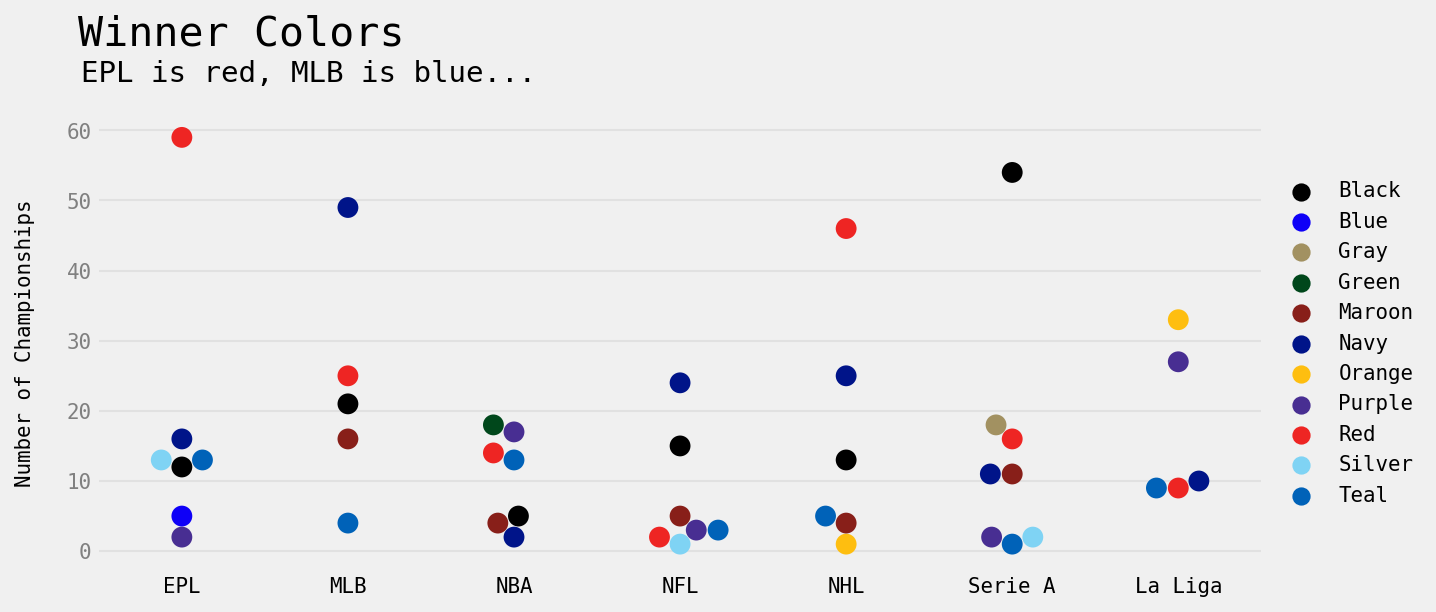

In [49]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

# plot
g = sns.swarmplot(data = winners.groupby(["wc_css2_Primary_Name", "League"])["Wins"].sum().reset_index(),
                  x="League", y="Wins",
                  hue="wc_css2_Primary_Name",
                  palette=webcolors_css2_p,
                  size = 10)
# text
plt.suptitle('Winner Colors', x=0.22, y=1.05, fontsize=20)
plt.title('EPL is red, MLB is blue...', x=0.18, y=1.05, fontsize=14)
plt.xlabel("")
plt.ylabel("Number of Championships\n")

# styling
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.yticks(color="gray")
plt.tick_params(length=0)
sns.despine(left=True, bottom=True)
g.grid(b=True, which='major', axis="y", color='lightgray', linewidth=1.0, alpha=0.5)

If you're familiar with any of these leagues, you can kind of eyeball which teams dominate the color of each league. Off the top of my head:
* EPL - Man U/Arsenal/Liverpool
* MLB - Yankees/Dodgers
* NBA - Celtics/Lakers
* NHL - Red Wings
* Serie A - Juventus

One thing that irks me in these color names is the classification of yellows as "Orange". We can hopefully solve this, as well as get more granularity, by looking at the color names from wolfram alpha. This feature has 30 unique color values vs. the 11 above.

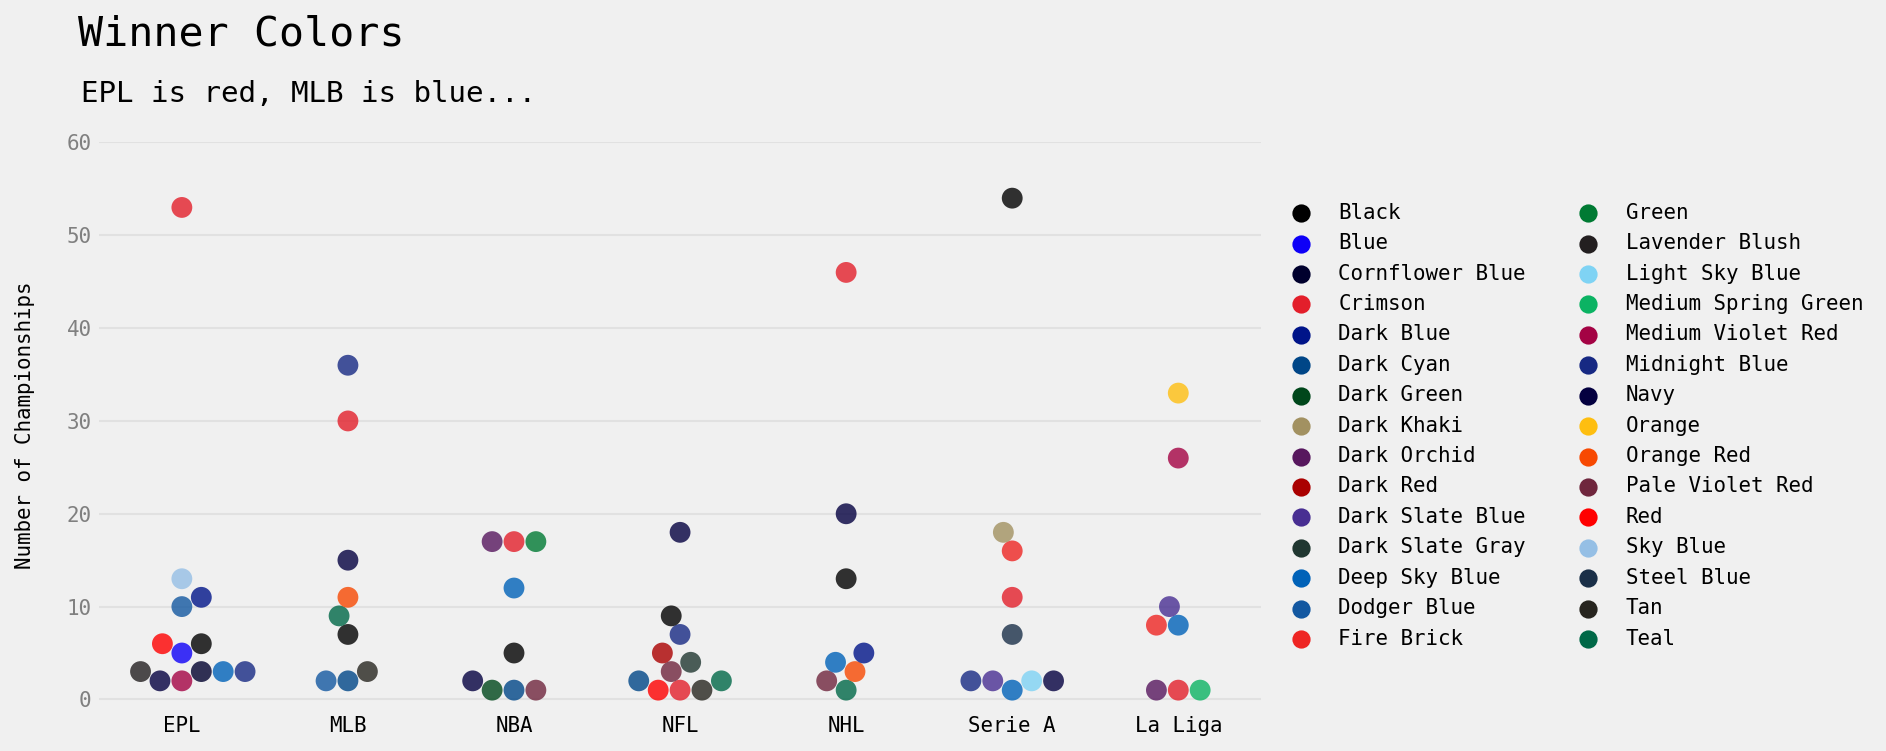

In [51]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# plot
g = sns.swarmplot(data = winners.groupby(["wa_Primary_Name_1", "League"])["Wins"].sum().reset_index(),
                  x="League", y="Wins",
                  hue="wa_Primary_Name_1", 
                  palette=wolfram_p_1,
                  size = 10,
                  alpha = 0.8)
# text
plt.suptitle('Winner Colors', x=0.22, y=1.05, fontsize=20)
plt.title('EPL is red, MLB is blue...', x=0.18, y=1.05, fontsize=14)
plt.xlabel("")
plt.ylabel("Number of Championships\n")

# styling
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, ncol=2)
g.grid(b=True, which='major', axis="y", color='lightgray', linewidth=1.0, alpha=0.5)
plt.yticks(color="gray")
plt.tick_params(length=0)
plt.ylim(-1, 60)
sns.despine(left=True, bottom=True)

Alright, sweet! We have a lot more color to this analysis both literally and figuratively. We can still see a lot of the dominant trends as in the plot before but more nuance as well. Some leagues still have some dominant colors (of which Crimson is in 3) but now the water is muddied around what color is dominant.

How about we look at these colors across all leagues, to see which color wins the most championships?

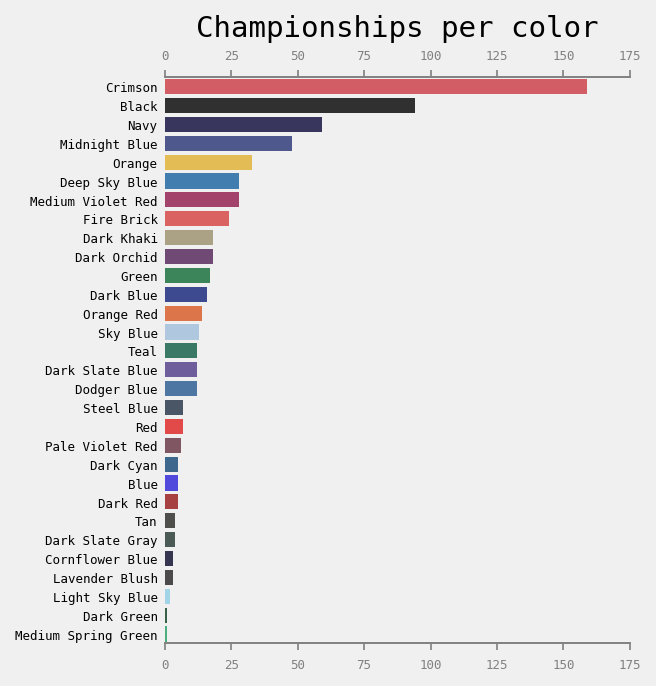

In [65]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=150)

# plot
g = sns.barplot(data = winners.groupby(["wa_Primary_Name_1"])["Wins"].
                       sum().
                       reset_index().
                       sort_values(by = ["Wins"], ascending=False),
                x = "Wins", y = "wa_Primary_Name_1",
                hue = "wa_Primary_Name_1", palette = wolfram_p_1, alpha=0.8, dodge=False)
# text
#plt.suptitle('Championships per color', x=0.18, y=1.05, fontsize=20)
plt.title('Championships per color', x=0.5, y=1.05, fontsize=14)
plt.ylabel("")
plt.xlabel("")

# styling
g.legend_.remove()
g.tick_params(color="gray")
plt.xlim(0, 175)
plt.tick_params(axis="y", length=0)
plt.xticks(color="gray", size=6)
plt.yticks(size = 6)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')

# add 2nd x-axis to top
axT = ax.twiny()
axT.set_xlim(0, 175)
axT.xaxis.set_major_locator(ticker.MultipleLocator(25))
axT.tick_params(axis='x', colors="gray", labelsize=6)
axT.spines['top'].set_color('gray')
axT.spines['bottom'].set_color("gray")
sns.despine(left=True, top=False)

I guess red teams really do win more...

For the sake of curiousity, let's look at the secondary colors of these winners.

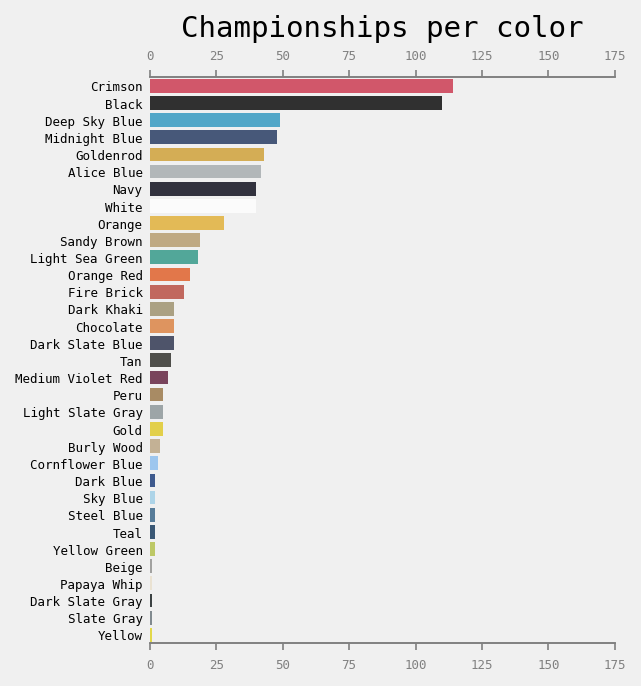

In [66]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=150)

# plot
g = sns.barplot(data = winners.groupby(["wa_Secondary_Name_1"])["Wins"].
                       sum().
                       reset_index().
                       sort_values(by = ["Wins"], ascending=False),
                x = "Wins", y = "wa_Secondary_Name_1",
                hue = "wa_Secondary_Name_1", palette = wolfram_s_1, alpha=0.8, dodge=False)
# text
#plt.suptitle('Championships per color', x=0.18, y=1.05, fontsize=20)
plt.title('Championships per color', x=0.5, y=1.05, fontsize=14)
plt.ylabel("")
plt.xlabel("")

# styling
g.legend_.remove()
g.tick_params(color="gray")
plt.xlim(0, 175)
plt.tick_params(axis="y", length=0)
plt.xticks(color="gray", size=6)
plt.yticks(size = 6)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')

# add 2nd x-axis to top
axT = ax.twiny()
axT.set_xlim(0, 175)
axT.xaxis.set_major_locator(ticker.MultipleLocator(25))
axT.tick_params(axis='x', colors="gray", labelsize=6)
axT.spines['top'].set_color('gray')
axT.spines['bottom'].set_color("gray")
sns.despine(left=True, top=False)

# PLOT DF OF COLORS AND WHETHER OR NOT THEY'VE WON IN EACH LEAGUE

In [189]:
temp = data.groupby(["wa_Secondary_Name_1", "League"])["Wins"].agg("sum").reset_index()
temp.head()

,wa_Secondary_Name_1,League,Wins
0,alice blue,MLB,30
1,alice blue,NBA,6
2,alice blue,NFL,4
3,alice blue,NHL,2
4,beige,NHL,1


In [26]:
import numpy as np
temp = data[["wa_Primary_Name_1", "League", "Wins"]]
#temp = temp.loc[temp["Wins"] > 0, "League"] = "Yes"
temp["Has_Won"] = np.where(temp["Wins"] > 0, "Yes", "No")

temp = temp[["wa_Primary_Name_1", "League", "Has_Won"]]
temp = temp.drop_duplicates().sort_values(by="wa_Primary_Name_1")
temp.head(20)

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,wa_Primary_Name_1,League,Has_Won
76,Black,MLB,Yes
93,Black,NHL,Yes
34,Black,NBA,No
129,Black,EPL,Yes
143,Black,Serie A,Yes
58,Black,NBA,Yes
24,Black,NFL,Yes
153,Blue,EPL,Yes
151,Cornflower Blue,EPL,Yes
0,Crimson,NFL,No


In [14]:
colors['League'].unique()

array(['NFL', 'NBA', 'MLB', 'NHL', 'EPL', 'La Liga', 'Serie A', 'NCAA'],
      dtype=object)

In [16]:
all_champs['League'].unique()

array(['EPL', 'La Liga', 'MLB', 'NBA', 'NFL', 'NHL', 'Serie A'],
      dtype=object)